# Calculating the Barycentric Timing Correction

When we observe stars using space-based telescopes, such as Kepler and TESS, the arrival time of photons is different to the time they would arrive at the solar system barycenter. For example, If the spacecraft is between the target and the solar system barycenter, the photons will arrive early. So that we can inter compare observations from different facilities, we provide the measurement along with the time those photons would have reached the solar system barycenter. 

`lkorbit` provdes a way to calculate this timing correction based on 

1. The time of the measurement **at the spacecraft**
2. The position of the spacecraft at that time
3. The position of the target

This example shows you how to calculate this for Kepler and TESS.

## Kepler example

Here we show how to calculate the barycenteric time correction. We'll use `lksearch` to download some Kepler data with which to test. We'll open the `.fits` file using `astropy`.

In [1]:
from lkorbit import KeplerSpacecraft
from lksearch import KeplerSearch
import numpy as np

from astropy.io import fits
from astropy.time import Time

In [2]:
# Download the file, obtain the local filename
fname = KeplerSearch("Kepler-10", exptime=1800).timeseries[5].download()["Local Path"][0]
# Open using astropy
hdulist = fits.open(fname)

We're going to use `lkorbit` to create the `KeplerSpacecraft` object

In [3]:
ks = KeplerSpacecraft()

Now we'll get the time array out of the data

In [4]:
time, time_corr = hdulist[1].data['TIME'], hdulist[1].data['TIMECORR']
k = np.isfinite(time)
time, time_corr = time[k], time_corr[k]

SPOC data contains two time extensions:
1. `TIME`: the time of the observations in Barycentric Julian Date (i.e. at the solar system barycenter)
2. `TIMECORR`: the time correction applied to the original spacecraft time, to obtain `TIME`

`lksearch` only works with spacecraft time. So we need to remove the SPOC applied time correction

In [5]:
t = time - time_corr

Kepler times are actually given in Barycentric **Kepler** Julian Date, which is BJD minus a constant. The constant is 2454833, we also store it for you in `lkorbit`.

In [6]:
ks.time_offset

2454833

In [7]:
t = time - time_corr + ks.time_offset

In [8]:
t

array([2455276.49115492, 2455276.51158862, 2455276.53202212, ...,
       2455371.11916292, 2455371.13959652, 2455371.16003002])

We will convert our time from a numpy array to an `astropy.time.Time` object, which will ensure this is a valid time.

In [9]:
t = Time(t, format='jd')

To calculate the arrival time we will need to know where the target is in the sky, which we can obtain from the fits file.

In [10]:
ra, dec = hdulist[1].header['RA_OBJ'], hdulist[1].header['DEC_OBJ']

Now we have the spacecraft time in julian date and target coordinates, we can calculate the time correction. 

In [12]:
ks.get_barycentric_time_correction(time=t, ra=ra, dec=dec)

array([-30.41441299, -30.37170985, -30.32899557, ..., 193.18638174,
       193.22012183, 193.25384805])

This is the correction that should be applied to the spacecraft time in order to give the light arrival time at the barycenter. Let's compare!

In [2]:
import matplotlib.pyplot as plt

NameError: name 't' is not defined

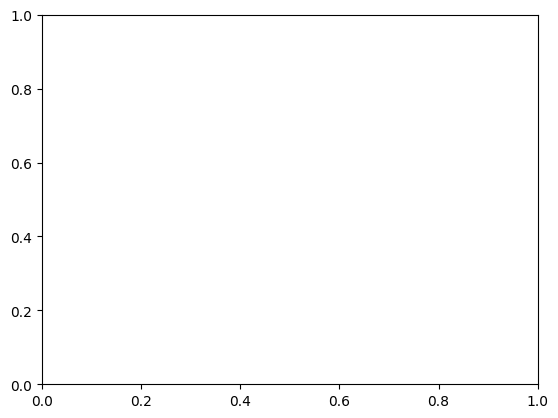

In [3]:
fig, ax = plt.subplots()
ax.plot(t.jd, time_corr * 86400, label='SPOC Time Correction', c='r')
ax.plot(t.jd, ks.get_barycentric_time_correction(time=t, ra=ra, dec=dec), label='`lkorbit` Time Correction', c='k')
ax.legend()
ax.set(xlabel='Spacecraft Time [JD]', ylabel='Barycentric Time Correction [s]', title=hdulist[0].header['OBJECT']);

Looks like our correction is working!

## TESS Example

TESS has a much wider FOV than the Kepler mission, and so there can be a significant difference between the barycentric correction for a target at the center of the field compared with a target at the edge of the field. 

This effect is not currently taken into account in TESScut TPFs. Let's use `lkorbit` to fix this.

In [16]:
from lksearch import TESSSearch
from lkorbit import TESSSpacecraft

In [17]:
# Download a TESScut TPF file, obtain the local filename
fname = TESSSearch("Kepler-10", hlsp=False).tesscut[0].download()['Local Path'][0]
# Open using astropy
hdulist = fits.open(fname)

In [18]:
ra, dec = hdulist[1].header['RA_OBJ'], hdulist[1].header['DEC_OBJ']

We'll load a new spacecraft this time, TESS!

In [19]:
ts = TESSSpacecraft()

In TESScut data there is a correction applied, but this is the correction at the middle of the FFI. Let's remove it

In [20]:
time, time_corr = hdulist[1].data['TIME'], hdulist[1].data['TIMECORR']
k = np.isfinite(time)
time, time_corr = time[k], time_corr[k]
t = Time(time - time_corr + ts.time_offset, format='jd')

In [21]:
ts.get_barycentric_time_correction(time=t, ra=ra, dec=dec)

array([155.38559868, 155.38850227, 155.39132197, ..., 148.89153462,
       148.88320421, 148.87483253])

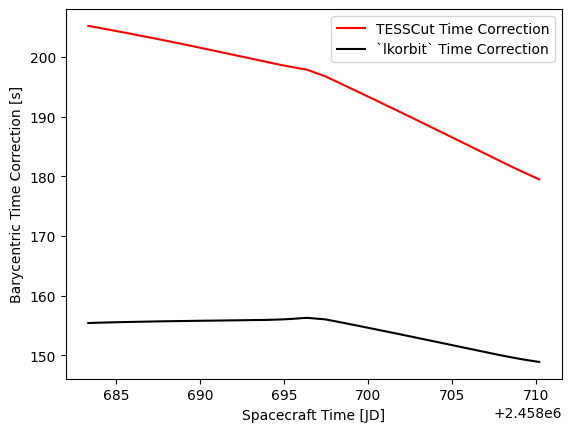

In [23]:
fig, ax = plt.subplots()
ax.plot(t.jd, time_corr * 86400, label='TESSCut Time Correction', c='r')
ax.plot(t.jd, ts.get_barycentric_time_correction(time=t, ra=ra, dec=dec), label='`lkorbit` Time Correction', c='k')
ax.legend()
ax.set(xlabel='Spacecraft Time [JD]', ylabel='Barycentric Time Correction [s]', title=hdulist[0].header['OBJECT']);

This time the stated time correction from TESSCut is incorrect, this is the time correction at the center of the FOV, not at our target. This can make a significant difference, the TESSCut data has photons arriving 40s too early!

Now you know about this time correction, you can apply it to any work on TESS FFI data.